# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy

from PIL import Image
from scipy import ndimage

%matplotlib inline

# Overview of the Data

- Load Data

In [2]:
def load_dataset():
    train_dataset = h5py.File('./datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('./datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

- Overview

In [4]:
train_x_orig.shape, test_x_orig.shape

((209, 64, 64, 3), (50, 64, 64, 3))

In [5]:
train_y.shape, test_y.shape

((1, 209), (1, 50))

In [6]:
classes

array([b'non-cat', b'cat'], dtype='|S7')

- Example

y = [1], it's a 'cat' picture.


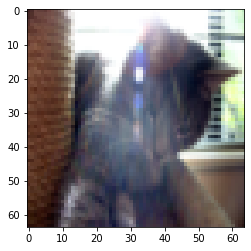

In [7]:
idx = 42
plt.imshow(train_x_orig[idx])
print("y = " + str(train_y[:, idx]) + ", it's a '" + classes[np.squeeze(train_y[:, idx])].decode("utf-8") + "' picture.")

# Preprocessing

1. Unrolling and Stacking instances in columns

In [8]:
m_train = train_x_orig.shape[0]
m_test = test_x_orig.shape[0]

In [9]:
train_x_flatten = train_x_orig.reshape(m_train, -1).T
test_x_flatten = test_x_orig.reshape(m_test, -1).T

2. Standardization

In [10]:
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

# Logistic Regression

## All parts of Alg

1. Helper functions - sigmoid

In [11]:
def sigmoid(z):
    s = 1. / (1 + np.exp(-z))
    
    return s

2. Initialization

In [12]:
def initialization_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0
    
    # Assertion
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

3. Forward & Backward propogation

In [13]:
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    # Forward Propogation
    Z = np.dot(w.T, X) + b
    A = sigmoid(Z)
    cost = 1. / m * np.sum(-(Y * np.log(A) + (1 - Y) * np.log(1 - A)), axis=1)
    
    # Backward Propogation
    dZ = A - Y
    dw = 1. / m * np.dot(X, dZ.T)
    db = 1. / m * np.sum(A - Y, axis=1)
    
    # Assertion
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw': dw, 'db': db}
    
    return grads, cost

4. Optimization

In [14]:
def optimize(w, b, X, Y, epochs, lr, print_cost=False):
    costs = []
    
    for i in range(epochs):
        # Compute costs and gradients
        grads, cost = propagate(w, b, X, Y)
        dw = grads['dw']
        db = grads['db']
        
        # Update w and b
        w -= lr * dw
        b -= lr * db
        
        # Record costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print cost every 100 iterations
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
    
    params = {'w': w, 'b': b}
    grads = {'dw': dw, 'db': db}
    
    return params, grads, costs

5. Prediction

In [15]:
def predict(w, b, X):
    m = X.shape[1]
    w = w.reshape(X.shape[0], 1)
    
    Z = np.dot(w.T, X) + b
    A = sigmoid(Z)
    Y_pred = (A > 0.5).astype(int)
    
    # Assertion
    assert(Y_pred.shape == (1, m))
    
    return Y_pred

## Merge into Model

In [16]:
def model(X_train, Y_train, X_test, Y_test, epochs=2000, lr=0.5, print_cost=False):
    # Initializtion
    w, b = initialization_zeros(X_train.shape[0])
    
    # Gradient Descent
    params, grads, costs = optimize(w, b, X_train, Y_train, epochs, lr, print_cost)
    
    # Retrieve trained parameters
    w = params['w']
    b = params['b']
    
    # Predict Train/Test
    Y_pred_train = predict(w, b, X_train)
    Y_pred_test = predict(w, b, X_test)
    
    # Train/Test Errors
    print("train acc: {}%".format(100 - np.mean(np.abs(Y_pred_train - Y_train)) * 100))
    print("test acc: {}%".format(100 - np.mean(np.abs(Y_pred_test - Y_test)) * 100))
    
    # Result
    res = {'costs': costs,
           'Y_pred_test': Y_pred_test,
           'Y_pred_train': Y_pred_train,
           'w': w,
           'b': b,
           'learning_rate': lr,
           'num_iterations': epochs}
    
    return res

## Experiment and Visualization

- Run

In [17]:
res = model(train_x, train_y, test_x, test_y, epochs=2000, lr=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train acc: 99.04306220095694%
test acc: 70.0%


- Example

y = 1, you predicted that it is a "cat" picture.


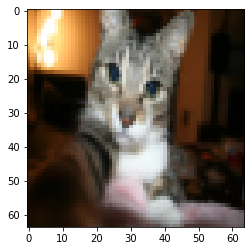

In [18]:
idx = 25
plt.imshow(test_x[:, idx].reshape((64, 64, 3)))
print ("y = " + str(test_y[0, idx]) + ", you predicted that it is a \"" + classes[res['Y_pred_test'][0,idx]].decode("utf-8") +  "\" picture.")

- Visualization - Learning Curve

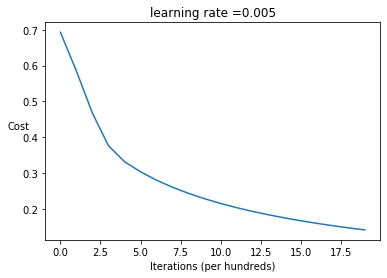

In [19]:
costs = np.squeeze(res['costs'])
plt.plot(costs)
plt.ylabel('Cost', rotation=0)
plt.xlabel('Iterations (per hundreds)')
plt.title("learning rate =" + str(res['learning_rate']))
plt.show()

## Further Analysis

- Choice of learning rate

learning rate is: 0.01
train acc: 99.52153110047847%
test acc: 68.0%
-----------------------------------------------------------------------------------------
learning rate is: 0.001
train acc: 88.99521531100478%
test acc: 64.0%
-----------------------------------------------------------------------------------------
learning rate is: 0.0001
train acc: 68.42105263157895%
test acc: 36.0%
-----------------------------------------------------------------------------------------


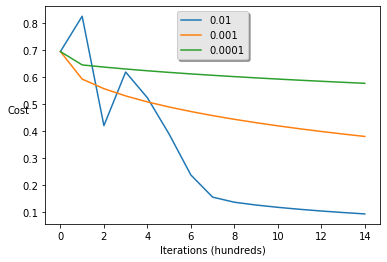

In [20]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print("learning rate is: " + str(lr))
    models[str(lr)] = model(train_x, train_y, test_x, test_y, epochs=1500, lr=lr, print_cost=False)
    print('-' * 89)

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]['costs']), label=str(models[str(lr)]['learning_rate']))

plt.ylabel('Cost', rotation=0)
plt.xlabel('Iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()